In [2]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F

In [3]:
class BottleneckBlock(nn.Module):
  def __init__(self, c_in, c_mid, c_out):
    super().__init__()
    self.c_in = c_in
    self.c_out = c_out

    self.conv1 = nn.Conv2d(c_in, c_mid, 1, 1)
    self.conv2 = nn.Conv2d(c_mid, c_mid, 3, 1, padding=1)
    self.conv3 = nn.Conv2d(c_mid, c_out, 1, 1)
    
  def forward(self, x):
    h = self.conv1(x)
    h = self.conv2(h)
    h = self.conv3(h)
    
    if self.c_in == self.c_out:
      h = x + h
    return h

In [4]:
resnet50 = nn.Sequential(
  nn.Conv2d(3, 64, 7, stride=2),
  nn.MaxPool2d((3, 3), stride=(2, 2), padding=0),

  BottleneckBlock(64, 64, 256),
  BottleneckBlock(256, 64, 256),
  BottleneckBlock(256, 64, 256),
  nn.MaxPool2d((2, 2), stride=(2, 2), padding=0),

  BottleneckBlock(256, 128, 512),
  BottleneckBlock(512, 128, 512),
  BottleneckBlock(512, 128, 512),
  BottleneckBlock(512, 128, 512),
  nn.MaxPool2d((2, 2), stride=(2, 2), padding=0),

  BottleneckBlock(512, 256, 1024),
  BottleneckBlock(1024, 256, 1024),
  BottleneckBlock(1024, 256, 1024),
  BottleneckBlock(1024, 256, 1024),
  BottleneckBlock(1024, 256, 1024),
  BottleneckBlock(1024, 256, 1024),
  nn.MaxPool2d((2, 2), stride=(2, 2), padding=0),

  BottleneckBlock(1024, 512, 2048),
  BottleneckBlock(2048, 512, 2048),
  BottleneckBlock(2048, 512, 2048),

  nn.AvgPool2d((7, 7)),
  nn.Flatten(2, -1),
  nn.Linear(2048, 1000),
  nn.LogSoftmax(1000)
)



# Starts Here

In [5]:
#score = H_conf, proposals = H_boxes
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
import os
import numpy as np

from PIL import Image

In [6]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
!unzip PennFudanPed.zip

--2021-06-30 01:27:42--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  26.6MB/s    in 1.9s    

2021-06-30 01:27:44 (26.6 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPed/Annotati

In [7]:
import matplotlib.pyplot as plt
class PedDataset(torch.utils.data.Dataset):
  def __init__(self, root):
    self.root = root
    self.names = [fname.split('.')[0] for fname in os.listdir(os.path.join(self.root, 'Annotation'))]
    print(self.names)

  def __getitem__(self, idx):
    name = self.names[idx]
    imgpath = os.path.join(self.root, 'PNGImages', name+'.png')
    img = np.array(Image.open(imgpath))
    
    maskpath = os.path.join(self.root, 'PedMasks', name+'_mask.png')
    mask = np.array(Image.open(maskpath))
    #plt.imshow(np.array(mask))
    
    mask_indices = np.unique(mask)[1:]
    masklist = (mask[None, :, :] == mask_indices[:, None, None]) # num_instances H W
    print(masklist.shape)
    boxlist = []
    for i in range(len(masklist)):
      mask = masklist[i]
      y, x = np.nonzero(mask)
      xx = np.min(x)
      xy = np.min(y)
      yx = np.max(x)
      yy = np.max(y)
      print(xx, xy, yx, yy)
      boxlist.append((xx, xy, yx, yy))

    clslist = []
    for mask in masklist:
      clslist.append(1)

    return img, clslist, boxlist, masklist
  def __len__(self):
    return len(self.names)
pd = PedDataset('PennFudanPed')
a = pd[1]
#a

['FudanPed00058', 'FudanPed00041', 'PennPed00056', 'FudanPed00025', 'FudanPed00062', 'PennPed00043', 'PennPed00088', 'PennPed00001', 'FudanPed00072', 'FudanPed00026', 'PennPed00028', 'FudanPed00038', 'FudanPed00046', 'PennPed00060', 'FudanPed00004', 'PennPed00082', 'FudanPed00070', 'PennPed00048', 'PennPed00076', 'FudanPed00047', 'PennPed00029', 'FudanPed00066', 'FudanPed00069', 'PennPed00027', 'PennPed00034', 'PennPed00016', 'FudanPed00029', 'PennPed00070', 'PennPed00084', 'PennPed00009', 'FudanPed00039', 'FudanPed00013', 'PennPed00069', 'PennPed00068', 'PennPed00030', 'PennPed00049', 'FudanPed00051', 'FudanPed00016', 'FudanPed00073', 'FudanPed00008', 'FudanPed00024', 'FudanPed00022', 'PennPed00037', 'PennPed00007', 'PennPed00061', 'FudanPed00065', 'PennPed00071', 'PennPed00072', 'FudanPed00057', 'PennPed00091', 'PennPed00035', 'PennPed00031', 'FudanPed00042', 'FudanPed00032', 'FudanPed00003', 'PennPed00013', 'FudanPed00009', 'FudanPed00028', 'FudanPed00059', 'PennPed00003', 'FudanPed

In [8]:
@torch.no_grad()
def collate_fn(batch):
  #print(123123)

  imgs, clslist, boxlist, masklist = tuple(zip(*batch))
  N = len(batch)
  K = sum([len(G) for G in clslist])
  #print(123123)
  ###tensoring
  imgs = [torchvision.transforms.functional.to_tensor(img) for img in imgs]
  GT_cls = [torch.tensor(l).long() for l in clslist]
  GT_box = [torch.tensor(lt) for lt in boxlist]
  GT_mask = [torch.tensor(lt, dtype=torch.float32) for lt in masklist] #[(L Hi Wi)...]
  ###img batching
  for i, img in enumerate(imgs):
    C, H, W = img.shape
    sH =  int(H * 400/min(H, W))
    sW =  int(W * 400/min(H, W))
    scale = 400/min(H, W)
    
    #sH, sW = int(H*scale), int(W*scale)
    print(f'sH: {sH}, sW: {sW}')
    img = torchvision.transforms.functional.resize(
        img, size=(sH, sW))
    imgs[i] = img
    GT_box[i] = (GT_box[i] * scale).int()
    #print(GT_mask[i].shape) #num_instances H W
    GT_mask[i] = F.interpolate(GT_mask[i][None, :, :, :], size=(sH, sW), mode='nearest')[0]

  maxh = max([img.shape[1] for img in imgs])
  maxw = max([img.shape[2] for img in imgs])
  maxh = int(np.ceil(maxh/32) * 32)
  maxw = int(np.ceil(maxw/32) * 32)
  print(maxh)
  X = torch.zeros(N, C, maxh, maxw)
  for i, img in enumerate(imgs):
    c, h, w = img.shape
    X[i, :c, :h, :w] = img[:, :, :]

  ####normalize when? in model.

  GT_mask_resized = []
  ###resize masking
  batch_indices = torch.tensor([i for i, l in enumerate(clslist) for _ in range(len(l))])

  for i, masks in enumerate(GT_mask):
    GT_mask = torch.zeros(len(masks), 14, 14)
    gt_box = GT_box[i]
    #print(masks.shape)
    for j, mask in enumerate(masks):
      print(mask.shape)
      print(gt_box[j])
      boxed_mask = mask[gt_box[j, 1]:gt_box[j, 3]+1, gt_box[j, 0]:gt_box[j, 2]+1]
      #print(boxed_mask.shape)
      resized_mask = F.interpolate(boxed_mask[None, None, :, :], size=(14, 14), mode='nearest')[0][0]
      GT_mask[j] = resized_mask

    GT_mask_resized.append(GT_mask)
  ### create batch_indices
  batch_indices = torch.tensor([i for i, l in enumerate(clslist) for _ in range(len(l))])
  #print(batch_indices.shape)
  return (X, GT_cls, GT_box, GT_mask_resized, batch_indices)
  
dl = torch.utils.data.DataLoader(
    pd,
    batch_size=2,
    shuffle=False,
    collate_fn=collate_fn
)
#a = next(iter(dl))

iter(dl)

In [9]:
a = [[1, 2], [3, 4], [5, 6]]
print(list(zip(*a)))

b = [1, 2, 3, 4]
for i, e in enumerate(b):
  e = 1
b[:1000]

[(1, 3, 5), (2, 4, 6)]


[1, 2, 3, 4]

In [10]:
import numpy as np
import torch
class AnchorGenerator(object):
  def __init__(self, ratio=(0.5, 1, 1.5), scale=(0.1, 0.3, 0.5)):
    self.ratio = np.array(ratio)
    self.scale = np.array(scale)
    
    sp = self.scale[:, None] / np.sqrt(self.ratio)[None, :] # 3 3
    anchor_wh = np.stack((sp * ratio, sp), axis=2) # 3 3 2
    anchor_wh = anchor_wh.reshape(-1, 2)
    anchor_wh = torch.tensor(anchor_wh, dtype=torch.float32)
    self.anchor_deltas = torch.cat((-anchor_wh/2, anchor_wh/2), dim=1) #9 4

  def generate_anchor(self, feature_hw=(28, 28), scale=(800, 800)):
    #feature_hw = (fh fw), scale = (hh ww)
    (fh, fw) = feature_hw
    (hh, ww) = scale

    print("A :", fh * fw * 9, ", fh, fw : ", fh, fw)
    feature_y = torch.arange(0, fh)/fh + 0.5/fh
    feature_x = torch.arange(0, fw)/fw + 0.5/fw
    feature_center = torch.stack(torch.meshgrid(feature_y, feature_x), dim=2) # fh, fw, 2
    feature_center = feature_center.repeat(1, 1, 2) # fh fw 2*2

    anchor_boxes = feature_center[:, :, None, :] + self.anchor_deltas[None, None, :, :]
    anchor_boxes = anchor_boxes.view(-1, 4)
    anchor_boxes[:, (0, 2)] = anchor_boxes[:, (0, 2)] * ww
    anchor_boxes[:, (1, 3)] = anchor_boxes[:, (1, 3)] * hh
    print('anchor_boxes: ', anchor_boxes.dtype)
    return anchor_boxes

ag = AnchorGenerator()
print(ag.generate_anchor().shape)

@torch.no_grad()
def match_anchor(anchor, GT_box):
  A, _ = anchor.shape
  N = len(GT_box)

  ious_val = torch.zeros(N, A)
  ious_idx = torch.zeros(N, A).long()
  for i, gt_box in enumerate(GT_box):
    G, _ = gt_box.shape
    tl = torch.maximum(anchor[:, None, :2], gt_box[None, :, :2])
    br = torch.minimum(anchor[:, None, 2:], gt_box[None, :, 2:])

    inter = (br - tl).sum(-1) * torch.all(tl < br, dim=-1) # A G
    area_a = (anchor[:, 2:] - anchor[:, :2]).sum(-1)
    area_b = (gt_box[:, 2:] - gt_box[:, :2]).sum(-1)

    iou = inter / (area_a[:, None] + area_b[None, :] - inter) # A G
    max_iou = torch.max(iou, dim=1)
    
    ious_val[i, :], ious_idx[i, :] = max_iou

  return ious_val, ious_idx

def smooth_l1(x):
  mask = (torch.abs(x) < 1).float()
  c1 = 0.5*x**2
  c2 = torch.abs(x) - 0.5
  return c1*mask + c2*(1-mask)

class RPN(nn.Module):
  def __init__(self,
               backbone,
               anchor_generator,
               rpn_head_conf,
               rpn_head_box,
               Y_neg_thres,
               Y_pos_thres,
               S,
               P, #Neg is S - P
               pre_nms_topk=2000,
               iou_thres=0.7,
               post_nms_topk=1000,
               ):
    super().__init__()
    self.backbone = backbone
    self.anchor_generator = anchor_generator
    self.rpn_head_conf = rpn_head_conf
    self.rpn_head_box = rpn_head_box
    self.Y_neg_thres = Y_neg_thres
    self.Y_pos_thres = Y_pos_thres
    self.S = S
    self.P = P
    self.pre_nms_topk = pre_nms_topk
    self.iou_thres = iou_thres
    self.post_nms_topk = post_nms_topk

  def nms_and_topk(self, H_box, H_conf):
    N, A, _ = H_box.shape

    nmsed_boxes = []
    nmsed_confs = []

    for i in range(N):
      h_box = H_box[i, :, :] # (A 4)
      h_conf = H_conf[i, :] # (A)

      _, pre_topk_idx = torch.topk(h_conf, k=self.pre_nms_topk, dim=0)
      h_box = h_box[pre_topk_idx, :]
      h_conf = h_conf[pre_topk_idx]

      nmsed_idx = torchvision.ops.nms(h_box, scores=h_conf, iou_threshold=self.iou_thres)

      post_topk_idx = nmsed_idx[:self.post_nms_topk]
      nmsed_boxes.append(h_box[post_topk_idx, :])
      nmsed_confs.append(h_conf[post_topk_idx])
    #nmsed_boxes [(num_nmsed, 4), ...] : sorted by conf
    return nmsed_boxes, nmsed_confs

  def idx_sampler(self, Y_conf, S=256, P=64):
    N, A = Y_conf.shape

    sampled_idxs = torch.zeros(N, S).long()
    for i in range(N):
      y_conf = Y_conf[i] # (A)
      y_pos_idx = (y_conf == 1).nonzero().squeeze(1) # (pp)
      pp, = y_pos_idx.shape
      y_neg_idx = (y_conf == 0).nonzero().squeeze(1) # (nn)
      nn, = y_neg_idx.shape

      p = min(P, pp)
      n = S - p
      sampled_pos_idx = y_pos_idx[torch.randperm(pp)[:p]] # (p)
      sampled_neg_idx = y_neg_idx[torch.randperm(nn)[:n]] # (n)
      sampled_idx = torch.cat((sampled_pos_idx, sampled_neg_idx), dim=0) # (S)
      sampled_idxs[i, :] = sampled_idx
      
    return sampled_idxs  # (N S)

  def get_L_conf(self, H_conf, Y_conf):
    N, A = Y_conf.shape

    sampled_idxs = self.idx_sampler(Y_conf) # (N S)
    ### idx is like: (0, 1), (0, 2), ... 
    ### (1, 5), (1, 2), ...
    ### all indices should have same shape
    ### because (think group of individual indexing)
    H_conf_sampled = H_conf[torch.arange(N)[:, None], sampled_idxs] # (N S)
    Y_conf_sampled = Y_conf[torch.arange(N)[:, None], sampled_idxs] # (N S)

    L_conf = F.binary_cross_entropy(H_conf_sampled, Y_conf_sampled, reduction='mean')
    return L_conf

  def get_pos_box(self, H_box, GT_box, anchor, ious_val, ious_idx):
    N, A, _ = H_box.shape

    H_pos_box = []
    Target_pos_box = []
    Anchor_pos = []

    Y_pos = (ious_val >= self.Y_pos_thres) # (N A)
    for i in range(N):
      y_pos = Y_pos[i]
      h_box = H_box[i, :, :] # (A 4)
      gt_box = GT_box[i] # (G 4)
      iou_idx = ious_idx[i, :] # (A)

      y_pos_idx = y_pos.nonzero().squeeze(1)
      iou_pos_idx = iou_idx[y_pos_idx]

      h_pos_box = h_box[y_pos_idx, :]
      target_pos_box = gt_box[iou_pos_idx, :]
      anchor_pos = anchor[y_pos_idx]
      
      H_pos_box.append(h_pos_box)
      Target_pos_box.append(target_pos_box)
      Anchor_pos.append(anchor_pos)
    
    return H_pos_box, Target_pos_box, Anchor_pos

  def create_Y_box(self, Target_pos_box, Anchor_pos):

    x_a = (Anchor_pos[:, 0] + Anchor_pos[:, 2]) / 2 # P
    y_a = (Anchor_pos[:, 1] + Anchor_pos[:, 3]) / 2
    w_a = (Anchor_pos[:, 2] - Anchor_pos[:, 0])
    h_a = (Anchor_pos[:, 3] - Anchor_pos[:, 1])

    t_x = (Target_pos_box[:, 0] - x_a[:]) / w_a # P
    t_y = (Target_pos_box[:, 1] - y_a[:]) / h_a
    t_w = torch.log(Target_pos_box[:, 2] / w_a[:]) # what if this is minus val. does not matter (gt is always pos)
    t_h = torch.log(Target_pos_box[:, 3] / h_a[:]) # what if this is minus val.
    
    Y_box = torch.stack((t_x, t_y, t_w, t_h), dim=1) # P 4
    return Y_box

  def get_L_box(self, H_box, GT_box, anchor, ious_val, ious_idx):
    N, A, _ = H_box.shape

    H_pos_box, Target_pos_box, Anchor_pos = self.get_pos_box(H_box, GT_box, anchor, ious_val, ious_idx)

    H_pos_box = torch.cat(H_pos_box, dim=0) # (PP 4)
    Target_pos_box= torch.cat(Target_pos_box, dim=0) # (PP 4)
    Anchor_pos = torch.cat(Anchor_pos, dim=0) # (PP 4)
    Y_box = self.create_Y_box(Target_pos_box, Anchor_pos) # (PP 4)
    PP, _ = Y_box.shape

    L_box = 1/PP * smooth_l1(H_pos_box - Y_box).sum()

    return L_box
  

  def forward(self, x, is_train=True, GT_box=None):
    N, _, hh, ww = x.shape
    
    H = self.backbone(x) # N C fh fw
    N, C, fh, fw = H.shape

    anchor = self.anchor_generator.generate_anchor(feature_hw=(fh, fw), scale=(hh, ww))
    A, _ = anchor.shape

    H_conf = self.rpn_head_conf(H)
    print('H_conf, anchor :', H_conf.shape, anchor.shape)
    H_conf = H_conf.permute(0, 2, 3, 1).reshape(N, A)
    H_box = self.rpn_head_box(H)
    H_box = H_box.permute(0, 2, 3, 1).reshape(N, A, 4)
    print('H_box:', H_box.dtype)

    loss = []
    if is_train:
      assert GT_box != None
      ious_val, ious_idx = match_anchor(anchor, GT_box) # (N A) (N A)
      Y_conf = torch.full((N, A), -1.)
      Y_conf[ious_val >= self.Y_pos_thres] = 1
      Y_conf[ious_val <= self.Y_neg_thres] = 0
      
      L_conf = self.get_L_conf(H_conf, Y_conf)
      L_box = self.get_L_box(H_box, GT_box, anchor, ious_val, ious_idx)
      loss = [L_conf, L_box]
    
    H_box = revert_H_box(H_box, anchor)

    nmsed_boxes, nmsed_confs = self.nms_and_topk(H_box, H_conf)


    return H, nmsed_boxes, nmsed_confs, loss

def xywh_to_xxyy(box, num_dim=2):
  x, y, w, h = box[..., 0], box[..., 1], box[..., 2], box[..., 3]
  xxyy_box = torch.stack((x - w/2, y - h/2, x + w/2, y + h/2), dim=num_dim-1)
  return xxyy_box

def revert_H_box(H_box, anchor):
  x_a = (anchor[:, 0] + anchor[:, 2]) / 2 # P
  y_a = (anchor[:, 1] + anchor[:, 3]) / 2
  w_a = (anchor[:, 2] - anchor[:, 0])
  h_a = (anchor[:, 3] - anchor[:, 1])

  #print(x_a, y_a, w_a, h_a)

  x = H_box[:, :, 0] * w_a + x_a # (N P)
  y = H_box[:, :, 1] * h_a + y_a
  w = torch.exp(H_box[:, :, 2]) * w_a
  h = torch.exp(H_box[:, :, 3]) * h_a
  xywh_H_box = torch.stack((x, y, w, h), dim=2)

  reverted_H_box = xywh_to_xxyy(xywh_H_box, num_dim=3)

  # reverted_H_box[:, :, (0, 2)] *= ww
  # reverted_H_box[:, :, (1, 3)] *= hh
  return reverted_H_box


A : 7056 , fh, fw :  28 28
anchor_boxes:  torch.float32
torch.Size([7056, 4])


In [11]:
def match_boxes(boxes, GT_box):
  #boxes : [(r 4), ... ]
  #GT_box : [(G 4), ...]
  N = len(GT_box)
  ious_val = []
  ious_idx = []

  for i in range(N):
    box = boxes[i]
    gt_box = GT_box[i]
    r, _ = box.shape
    G, _ = gt_box.shape

    tl = torch.maximum(box[:, None, :2], gt_box[None, :, :2])
    br = torch.minimum(box[:, None, 2:], gt_box[None, :, 2:])

    inter = (br - tl).sum(-1) * torch.all(tl < br, dim=-1) # (r G)
    area_a = (box[:, 2:] - box[:, :2]).sum(-1)
    area_b = (gt_box[:, 2:] - gt_box[:, :2]).sum(-1)
    iou = inter / (area_a[:, None] + area_b[None, :] - inter) # (r G)
    
    max_iou = torch.max(iou, dim=1)
    iou_val, iou_idx = max_iou
    ious_val.append(iou_val)
    ious_idx.append(iou_idx)

  return ious_val, ious_idx

In [12]:
def selector(ious_val, ious_idx, nmsed_boxes, GT_cls, GT_box, GT_mask, S=512, P=256):
  N = len(ious_val)

  selected_nmsed_boxes = []
  selected_GT_cls = []
  selected_GT_box = []
  selected_GT_mask = []

  for iou_val, iou_idx, nmsed_box, gt_box, gt_cls, gt_mask \
    in zip(ious_val, ious_idx, nmsed_boxes, GT_box, GT_cls, GT_mask):

    gt_box = gt_box[iou_idx]
    gt_cls = gt_cls[iou_idx]
    gt_mask = gt_mask[iou_idx]

    y_pos = (iou_val >= 0.5)
    y_neg = torch.logical_and((iou_val >= 0.1), (iou_val < 0.5))
    
    y_pos_idx = y_pos.nonzero().squeeze(1)
    y_neg_idx = y_neg.nonzero().squeeze(1)
    
    pp, = y_pos_idx.shape
    nn, = y_neg_idx.shape


    p = min(P, pp)
    n = min(S - p, nn)
    sampled_pos_idx = y_pos_idx[torch.randperm(pp)[:p]] # (p)
    sampled_neg_idx = y_neg_idx[torch.randperm(nn)[:n]] # (n)
    sampled_idx = torch.cat((sampled_pos_idx, sampled_neg_idx), dim=0) # (S) 
    sampled_y_score = torch.cat((torch.ones(p).long(), torch.zeros(n).long()), dim=0)
    print('s, pp, nn, p, n:', S, pp, nn, p, n)

    nmsed_box = nmsed_box[sampled_idx, :]
    gt_cls = gt_cls[sampled_idx]
    gt_cls = gt_cls * sampled_y_score # background to 0
    gt_box = gt_box[sampled_idx, :]
    gt_mask = gt_mask[sampled_idx, :, :]

    selected_nmsed_boxes.append(nmsed_box)
    selected_GT_cls.append(gt_cls)
    selected_GT_box.append(gt_box)
    selected_GT_mask.append(gt_mask)
  
  batch_idxs = [i for i, nb in enumerate(selected_nmsed_boxes) for _ in range(len(nb))]
  batch_idxs = torch.tensor(batch_idxs).unsqueeze(1)
  nmsed_boxes = torch.cat(selected_nmsed_boxes, dim=0)
  nmsed_boxes = torch.cat((batch_idxs, nmsed_boxes), dim=1)
  GT_cls = torch.cat(selected_GT_cls, dim=0)
  GT_box = torch.cat(selected_GT_box, dim=0)
  GT_mask = torch.cat(selected_GT_mask, dim=0)

  return nmsed_boxes, GT_box, GT_cls, GT_mask

In [13]:
class RoIHead(nn.Module):
  def __init__(self, features_net, num_classes=80):
    super().__init__()
    self.features_net = features_net
    self.roi_head_cls = nn.Sequential(
      nn.Linear(2048, num_classes)
    )
    self.roi_head_box = nn.Sequential(
        nn.Linear(2048, 4)
    )
    self.roi_head_mask = nn.Sequential(
        nn.ConvTranspose2d(2048, 256, kernel_size=(2, 2), stride=(2, 2)),
        nn.Conv2d(256, num_classes, 1, 1),
        nn.Sigmoid()
    )

  def forward(self, features, nmsed_boxes, is_train=True, GT_cls=None, GT_box=None, GT_mask=None, img_shape=(2, 3, 600, 600)):
    N, C, fh, fw = features.shape
    _, _, hh, hw = img_shape

    ious_val, ious_idx = match_boxes(nmsed_boxes, GT_box)

    nmsed_boxes, GT_box, GT_cls, GT_mask = selector(ious_val, ious_idx, nmsed_boxes, GT_cls, GT_box, GT_mask)
    #draw_boxes(nmsed_boxes, img=X[0].permute(1, 2, 0).numpy())
    
    aligned_features = torchvision.ops.roi_align(features, boxes=nmsed_boxes, output_size=(7, 7), 
                                                spatial_scale=fh/hh, sampling_ratio=2)
    K, C, m, m = aligned_features.shape

    H = self.features_net(aligned_features) # K C m m
    ave = F.adaptive_avg_pool2d(H, (1, 1)).flatten(1, -1) #K C 

    H_cls = self.roi_head_cls(ave) # K C
    H_box = self.roi_head_box(ave) # K 4 
    H_mask = self.roi_head_mask(H) # K n_cls m m

    L = []
    if is_train:  
      L_cls = F.cross_entropy(H_cls, GT_cls, reduction='mean')
      
      Y_pos = (GT_cls >= 1)
      L_box = 1/sum(Y_pos) * smooth_l1(H_box[Y_pos] - GT_box[Y_pos]).sum()

      H_mask_target = H_mask[np.arange(K), GT_cls, :, :] # k m m 
      H_mask_target = H_mask_target.flatten(1, -1)
      GT_mask = GT_mask.flatten(1,-1)
      L_mask = F.binary_cross_entropy(H_mask_target, GT_mask)
      L = [L_cls, L_box, L_mask]
    
    if nmsed_boxes is not None and is_train == False:
      H_box = revert_H_box(H_box[None, :, :], nmsed_boxes).squeeze(0)
      # for i in range(K): mask resizing is the role of caller
      #   #H_mask.resize()
    
    return H_cls, H_box, H_mask, L

In [14]:
class Mask_RCNN(nn.Module):
  def __init__(self, rpn, roi_head):
    super().__init__()
    self.rpn = rpn
    self.roi_head = roi_head
    
  def forward(self, X, GT_cls, GT_box, GT_mask_resized, pixel_mean=0.5, pixel_std=0.3):
    N, _, hh, ww = X.shape
    X = (X - pixel_mean) / pixel_std
    
    features, nmsed_boxes, nmsed_confs, L_rpn = self.rpn(X, is_train=True, GT_box=GT_box)

    H_cls, H_box, H_mask, L_roi_head = self.roi_head(features, nmsed_boxes, True, GT_cls, GT_box, GT_mask_resized, img_shape=X.shape)

    return H_cls, H_box, H_mask, L_rpn, L_roi_head

  def inference(self, img, pixel_mean=0.5, pixel_std=0.3):
    #img : C H W
    features, nmsed_boxes, nmsed_confs, L_rpn = self.rpn(X, is_train=False, GT_box=GT_box)
    H_cls, H_box, H_mask, L_roi_head = self.roi_head(features, nmsed_boxes, False, GT_cls, GT_box, GT_mask_resized, img_shape=X.shape)
    
    return H_cls, H_box, H_mask


In [15]:
rpn_head_conf = nn.Sequential(
    nn.Conv2d(1024, 9*1, 1, 1),
    nn.Sigmoid()
)
rpn_head_box = nn.Conv2d(1024, 9*4, 1, 1)
rpn = RPN(resnet50[:17], ag, rpn_head_conf, rpn_head_box, 
          Y_neg_thres=0.3,
          Y_pos_thres=0.5, 
          S=256,
          P=64,
          pre_nms_topk=2000,
          iou_thres=0.7,
          post_nms_topk=1000,
          )

roi_head = RoIHead(features_net=resnet50[18:21], num_classes=80)

mask_rcnn = Mask_RCNN(rpn, roi_head)

(X, GT_cls, GT_box, GT_mask_resized, batch_indices) = next(iter(dl))
H_cls, H_box, H_mask, L_rpn, L_roi_head = mask_rcnn(X, GT_cls, GT_box, GT_mask_resized)

(8, 479, 522)
144 91 260 462
42 122 63 210
288 101 340 279
352 96 405 275
426 125 445 181
461 125 473 170
472 132 488 182
491 120 516 201
(3, 507, 552)
350 160 438 436
283 180 356 438
41 185 109 387
sH: 400, sW: 435
sH: 400, sW: 435
416
torch.Size([400, 435])
tensor([120,  75, 217, 385], dtype=torch.int32)
torch.Size([400, 435])
tensor([ 35, 101,  52, 175], dtype=torch.int32)
torch.Size([400, 435])
tensor([240,  84, 283, 232], dtype=torch.int32)
torch.Size([400, 435])
tensor([293,  80, 338, 229], dtype=torch.int32)
torch.Size([400, 435])
tensor([355, 104, 371, 151], dtype=torch.int32)
torch.Size([400, 435])
tensor([384, 104, 394, 141], dtype=torch.int32)
torch.Size([400, 435])
tensor([394, 110, 407, 151], dtype=torch.int32)
torch.Size([400, 435])
tensor([410, 100, 430, 167], dtype=torch.int32)
torch.Size([400, 435])
tensor([276, 126, 345, 343], dtype=torch.int32)
torch.Size([400, 435])
tensor([223, 142, 280, 345], dtype=torch.int32)
torch.Size([400, 435])
tensor([ 32, 145,  85, 305], d

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


A : 6075 , fh, fw :  25 27
anchor_boxes:  torch.float32
H_conf, anchor : torch.Size([2, 9, 25, 27]) torch.Size([6075, 4])
H_box: torch.float32
s, pp, nn, p, n: 512 29 498 29 483
s, pp, nn, p, n: 512 21 423 21 423


In [16]:
PATH = './model_info/model_state'

#model.load_state_dict(torch.load(PATH))
#torch.save(model.state_dict(), PATH)

# model_info = {
#     'iter':iter
#     'model_state_dict':model.state_dict(),
#     'optimizer_state_dict':optimizer.state_dict(),
#     'scheduler_state_dict':scheduler.state_dict()
# }


In [17]:
class Evaluator(object):
  def __init__(self):
    super().__init__()
    return
  
  def evaluate(self):
    pass
evaluator = Evaluator()

In [19]:
def create_clip_optimizer_class(optimizer_type, max_norm=1):
  def optimizer_wgc_step(self, closure=None):
    for group in self.param_groups:
      for p in group["params"]:
        torch.nn.utils.clip_grad_norm_(p, max_norm=max_norm)
    return super(type(self), self).step(closure)

  OptimizerWithGradientClip = type( #types.new_class
      optimizer_type.__name__ + "WithGradClip",
      (optimizer_type,),
      {"step": optimizer_wgc_step},
  )

  #get params for optimizer

  return OptimizerWithGradientClip

In [20]:
class MultiStepParamScheduler(object):
  def __init__(self, values, milestones, num_updates):
    #[v, ...], [m, ...], int
    super().__init__()
    self.values = values
    self.milestones = milestones
    self.num_updates = num_updates

    self._milestones = milestones + [num_updates]

  def __call__(self, frac):
    iteration = frac * self.num_updates
    
    #linear search
    i = 0
    while iteration >= self._milestones[i]: # iter does not go beyond num_updates
      i += 1
    #bisect.bisect_right(_milestones, iter)
    return self.values[i]
    
class Scheduler(torch.optim.lr_scheduler._LRScheduler):
  def __init__(self, optimizer, multiplier, max_iter, last_iter=-1):
    self._multiplier = multiplier
    self._max_iter = max_iter
    super().__init__(optimizer, last_epoch=last_iter)

  def state_dict(self):
    return {"base_lrs": self.base_lrs, "last_epoch": self.last_epoch}

  def get_lr(self):
    multiplier = self._multiplier(self.last_epoch / self._max_iter)
    return [base_lr * multiplier for base_lr in self.base_lrs]

In [21]:
MAX_ITER=20000
start_iter = 5
def train_one_epoch(dl, model, opt, sched=None, load_path=None):
  if load_path:
    model_info = torch.load(PATH)
    iter = model_info["iter"]
    model.load_state_dict(model_info["model_state_dict"])
  else:
    iter = 0

  for iteration, batch_inputs in zip(range(start_iter+1, MAX_ITER), dl):
    print(len(batch_inputs))
    print(batch_inputs[0])
    X, GT_cls, GT_box, GT_mask_resized, batch_indices = batch_inputs
    
    H_cls, H_box, H_mask, L_rpn, L_roi_head = model(X, GT_cls, GT_box, GT_mask_resized)
    
    L = L_rpn + L_roi_head
    
    loss = sum(L)

    opt.zero_grad()
    loss.backward()
    opt.step()

  if sched:
    sched.step(iteration)

  if iteration % 20 == 0:
    print(f'iter {iteration}, loss: {L}')
    print(f'lr : {opt.param_groups[0]["lr"]}')
  
  if iteration % 20 == 0:  
    evaluator.evaluate()

  if iteration % 20 == 0:
    model_info = {
      'iter':iter,
      'model_state_dict':model.state_dict(),
      'optimizer_state_dict':optimizer.state_dict(),
      'scheduler_state_dict':scheduler.state_dict()
    }
    torch.save(model_info, PATH)


mask_rcnn = Mask_RCNN(rpn, roi_head)
#optimizer = torch.optim.SGD(mask_rcnn.parameters(), lr=0.001, weight_decay=0.01)
ClipOptimizer = create_clip_optimizer_class(torch.optim.SGD, max_norm=0.5)
clip_optimizer = ClipOptimizer(mask_rcnn.parameters(), lr=0.001, weight_decay=0.01)
scheduler = Scheduler(
    clip_optimizer,
    MultiStepParamScheduler(
        [1, 0.1, 0.01],
        milestones=[20000, 25000, 30000],
        num_updates=30000
    ),
    max_iter=30000
)

n_epochs = 10
for i in range(n_epochs):
  train_one_epoch(dl, mask_rcnn, clip_optimizer, scheduler)

(8, 479, 522)
144 91 260 462
42 122 63 210
288 101 340 279
352 96 405 275
426 125 445 181
461 125 473 170
472 132 488 182
491 120 516 201
(3, 507, 552)
350 160 438 436
283 180 356 438
41 185 109 387
sH: 400, sW: 435
sH: 400, sW: 435
416
torch.Size([400, 435])
tensor([120,  75, 217, 385], dtype=torch.int32)
torch.Size([400, 435])
tensor([ 35, 101,  52, 175], dtype=torch.int32)
torch.Size([400, 435])
tensor([240,  84, 283, 232], dtype=torch.int32)
torch.Size([400, 435])
tensor([293,  80, 338, 229], dtype=torch.int32)
torch.Size([400, 435])
tensor([355, 104, 371, 151], dtype=torch.int32)
torch.Size([400, 435])
tensor([384, 104, 394, 141], dtype=torch.int32)
torch.Size([400, 435])
tensor([394, 110, 407, 151], dtype=torch.int32)
torch.Size([400, 435])
tensor([410, 100, 430, 167], dtype=torch.int32)
torch.Size([400, 435])
tensor([276, 126, 345, 343], dtype=torch.int32)
torch.Size([400, 435])
tensor([223, 142, 280, 345], dtype=torch.int32)
torch.Size([400, 435])
tensor([ 32, 145,  85, 305], d

KeyboardInterrupt: ignored

In [33]:
def draw_boxes(boxes, img=None):
  import matplotlib.pyplot as plt
  from matplotlib.patches import Rectangle
  fig = plt.figure(0)
  if img is not None:
    plt.imshow(img)
  
  for i in range(len(boxes)):
    box = boxes[i]
    xx = box[0]
    xy = box[1]
    w = box[2] - box[0]
    h = box[3] - box[1]
    plt.gca().add_patch(Rectangle((xx,xy),w,h,linewidth=1,edgecolor='r',facecolor='none'))
  
  return fig

In [34]:
class Visualizer(object):
  def __init__(self, img):
    self.img = img
    self.output = img

  def draw_instance_predictions(self, predictions):
    H_cls, H_box, H_mask = predictions
    self.output = draw_boxes(H_box, img=img)
    return self.output

  def get_output(self):
    return self.output

def inference(img, model):
  # img : H W C
  vis = Visualizer(img)
  with torch.no_grad():
    img_tensor = torch.tensor(img).permute(2, 0, 1)
    H_cls, H_box, H_mask = model.inference(img_tensor)
    
    
    ### mask reshaping
    vis.draw_instance_predictions((H_cls, H_box, H_mask))
    out = vis.get_output()
    #fig.imshow(out)


(8, 479, 522)
144 91 260 462
42 122 63 210
288 101 340 279
352 96 405 275
426 125 445 181
461 125 473 170
472 132 488 182
491 120 516 201
A : 6075 , fh, fw :  25 27
anchor_boxes:  torch.float32
H_conf, anchor : torch.Size([2, 9, 25, 27]) torch.Size([6075, 4])
H_box: torch.float32
s, pp, nn, p, n: 512 29 501 29 483
s, pp, nn, p, n: 512 24 437 24 437


TypeError: ignored

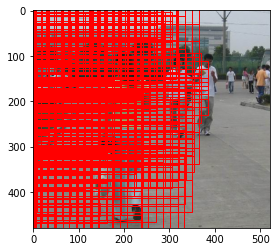

In [35]:
img = pd[0][0] # img
inference(img, mask_rcnn)

In [30]:
H_mask.shape

torch.Size([956, 80, 14, 14])

In [ ]:
scheduler = Scheduler(
    clip_optimizer,
    MultiStepParamScheduler(
        [1, 0.1, 0.01],
        milestones=[20000, 25000, 30000],
        num_updates=30000
    ),
    max_iter=30000
)
print(scheduler.state_dict())

In [ ]:
a = torch.zeros(5, 10)
idx = torch.zeros(5, 2, dtype=torch.long)
a[torch.arange(5)[:, None], idx].shape

In [ ]:
print(H_box)
draw_boxes(H_box, img=X[0].permute(1, 2, 0).numpy())


In [ ]:
draw_boxes(h_box)
draw_boxes(gt_box)

In [ ]:
rpn_head_conf = nn.Sequential(
    nn.Conv2d(1024, 9*1, 1, 1),
    nn.Sigmoid()
)
rpn_head_box = nn.Conv2d(1024, 9*4, 1, 1)
rpn = RPN(resnet50[:17], ag, rpn_head_conf, rpn_head_box, 0, 0, 0, 0)
(X, GT_cls, GT_box, GT_mask_resized, batch_indices) = next(iter(dl))

features, H_conf, H_box, L = rpn(X, is_train=True, GT_box=GT_box)
torchvision.ops.nms(H_box, )

In [ ]:
def xywh_to_xxyy(box):
  x, y, w, h = box[:, 0], box[:, 1], box[:, 2], box[:, 3]
  xxyy = torch.stack((x - w/2, y - h/2, x + w/2, y + h/2), dim=1)
  return xxyy

def unpack_H_box(H_box, anchor):
  anchor_boxes = anchor
  x_a = (anchor_boxes[:, 0] + anchor_boxes[:, 2]) / 2 # P
  y_a = (anchor_boxes[:, 1] + anchor_boxes[:, 3]) / 2
  w_a = (anchor_boxes[:, 2] - anchor_boxes[:, 0])
  h_a = (anchor_boxes[:, 3] - anchor_boxes[:, 1])

  x = H_box[:, 0] * w_a + x_a
  y = H_box[:, 1] * h_a + y_a
  w = torch.exp(H_box[:, 2]) * w_a
  h = torch.exp(H_box[:, 3]) * h_a

  unpacked_H_box = xywh_to_xxyy(torch.stack((x, y, w, h), dim=1))
  return unpacked_H_box

In [ ]:
###neck
#unpack_H_box

# t_x = (Y_box[:, :, 0] - x_a[None, :, None]) / w_a
# t_y = (Y_box[:, :, 1] - y_a[None, :, None]) / h_a
# t_w = torch.log(Y_box[:, :, 2] / w_a[None, :, None]) # what if this is minus val.
# t_w = torch.log(Y_box[:, :, 3] / h_a[None, :, None]) # what if this is minus val.

#nms


# def unpack_h_box(H_box, anchor):
#   x_a = (anchor_boxes[:, 0] + anchor_boxes[:, 2]) / 2 # P
#   y_a = (anchor_boxes[:, 1] + anchor_boxes[:, 3]) / 2
#   w_a = (anchor_boxes[:, 2] - anchor_boxes[:, 0])
#   h_a = (anchor_boxes[:, 3] - anchor_boxes[:, 1])

#   t_x = (y_box[:, 0] - x_a[:]) / w_a # P
#   t_y = (y_box[:, 1] - y_a[:]) / h_a
#   t_w = torch.log(y_box[:, 2] / w_a[:]) # what if this is minus val. does not matter (gt is always pos)
#   t_h = torch.log(y_box[:, 3] / h_a[:]) # what if this is minus val.



nmsed_H_boxes = list()
nmsed_anchors = list()
for i in range(N):
  nmsed_H_box_idx = torchvision.ops.nms(boxes=unpacked_H_box[i], scores=H_conf[i], iou_threshold=0.7)
  nmsed_H_box = H_box[nmsed_H_box_idx]
  nmsed_H_boxes.append(nmsed_H_box)

  thres = 0.5
  pos_anchor = anchor[H_conf >= thres]
  nmsed_anchor = pos_anchor[nmsed_H_box_idx]
  nmsed_anchors.append(nmsed_anchor)

#roi align
H, W = X.size(2), X.size(3)
roihead_features = torchvision.ops.roi_align(features, boxes=nmsed_H_boxes, output_size=(7, 7), spatial_scale=features.shape[2]/H) # feature_H / H
#K C hi wi

In [ ]:
num_classes=80

###RoI Head
class RoIHead(nn.Module):
  def __init__(self):
    super().__init__()
    self.features_net = resnet50[15:18]
    self.roihead_cls = nn.Sequential(
      nn.Linear(2048, num_classes)
    )
    self.roihead_box = nn.Sequential(
        nn.Linear(2048, 4)
    )
    self.roihead_mask = nn.Sequential(
        nn.ConvTranspose2d(2048, 256, kernel_size=(2, 2), stride=(2, 2)),
        nn.Conv2d(256, 80, 1, 1),
        nn.Sigmoid()
    )
    m=14
    self.m = m

  def forward(self, x, GT_box, GT_cls, GT_mask):
    #x: K C hi wi
    #GT_box: K 4
    #GT_cls: K
    #GT_idx: K #target img idx in batch
    #GT_mask: K m m, 1....00....
    ###features
    H = self.features_net(x) # K C hi wi
    
    ###get class
    ave = F.adaptive_avg_pool2d(H, (1, 1)).flatten(1, -1) #K C
    
    
    H_cls = self.roihead_cls(ave)
    H_box = self.roihead_box(ave)
    H_mask = self.roihead_mask(H) # K n_cls m m


    L_cls = F.cross_entropy(H_cls, GT_cls)
    L_box = smooth_l1(H_box - GT_box).sum() # A 4

    H_mask_target = H_mask[np.arange(len(GT_cls)), GT_cls, :, :].flatten(1, -1) #k m m -> k m*m
    print(H_mask_target.shape, GT_mask.shape)
    L_mask = F.binary_cross_entropy(H_mask_target, GT_mask.flatten(1, -1))
    L = L_cls + L_box + L_mask
    return H_cls, H_box, H_mask, L

In [ ]:
(X, GT_cls, GT_box, GT_mask_resized, batch_indices) = next(iter(dl))
GT_box = [gt_box.float() for gt_box in GT_box]
N, _, hh, ww = X.shape
roihead_features = torchvision.ops.roi_align(features, boxes=GT_box, output_size=(7, 7), spatial_scale=features.shape[2]/hh) # -> K 4
GT_box = torch.cat(GT_box, dim=0)
GT_cls = torch.cat(GT_cls, dim=0)
GT_mask_resized = torch.cat(GT_mask_resized, dim=0)
roihead = RoIHead()
H_cls, H_box, H_mask, L = roihead(roihead_features, GT_box, GT_cls, GT_mask_resized)